# Capstone 2 Modeling (day)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pmdarima.metrics import smape # Symmetric Mean Absolute Percentage Error.
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline

In [2]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
dfts = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\dfts.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
dfts.index = pd.to_datetime(dfts.index)
# set the index frequency
df2.index.freq="D"
df6.index.freq="D"
df7.index.freq="D"

In [3]:
# dfts doesn't have 24 hours, so we will reindex it and fill in the missing hours with 0
dfts = dfts.reindex(pd.date_range('2016-01-04', periods=22560, freq='h'), fill_value=0)
# check for total number of hours
display(len(dfts))
# check and see if there's NaN
display(dfts.isnull().any())
display(dfts.head())
display(dfts.tail())

22560

sales    False
dtype: bool

,sales
2016-01-04 00:00:00,0.0
2016-01-04 01:00:00,0.0
2016-01-04 02:00:00,0.0
2016-01-04 03:00:00,0.0
2016-01-04 04:00:00,0.0


,sales
2018-07-31 19:00:00,0.0
2018-07-31 20:00:00,0.0
2018-07-31 21:00:00,0.0
2018-07-31 22:00:00,0.0
2018-07-31 23:00:00,0.0


We will use 9/1/2017 until end of 2017 as testing date, while forecasting until end of March 2018 to verify the prediction should go up by end of March.

# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

In [4]:
#train_test_split and forecast dates
train_start,train_end = '2016-01-04 00','2017-08-31 23'
train = dfts[train_start:train_end].dropna()

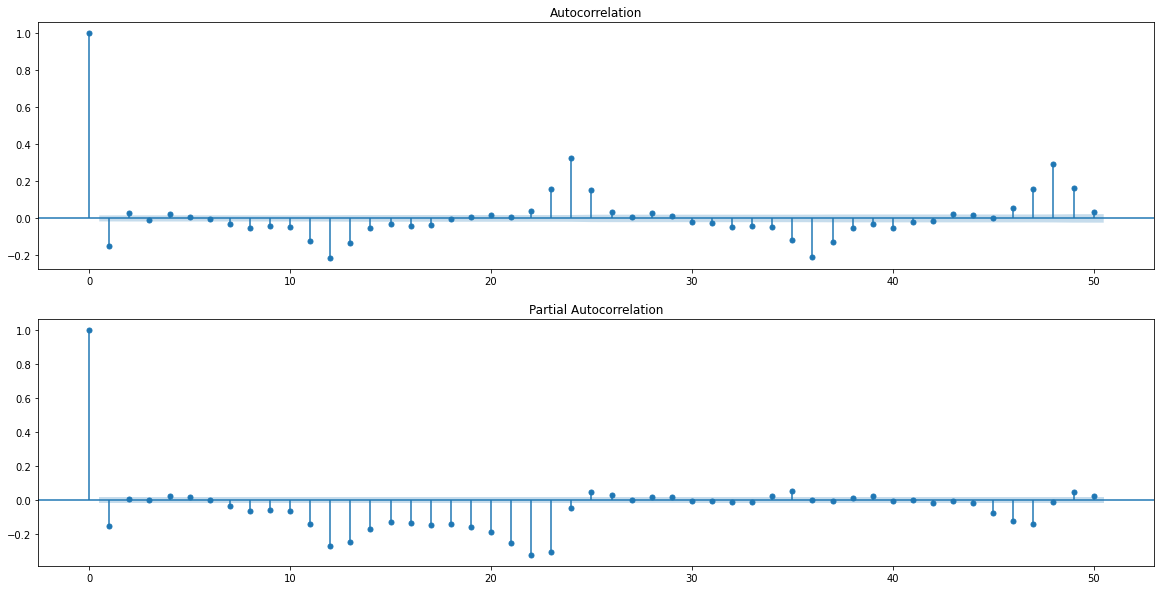

In [5]:
#we use train.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 24 periods, indicating a daily pattern exists; hence p=24.
Since our time series data is stationary, no differencing is needed, so d=0.

In [15]:
# create empty lists to save the data
model_list = []
r2_list = []
mean_SE_list = []
mean_AE_list = []
smape_list = []
aic_list = []

In [7]:
#need to change working directory to figure so we can save the figures in its folder
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

# ARIMAX Modeling
From modeling the daily sales data ARIMAX performed well, so we will try it for hourly.

In [8]:
#train_test_split and forecast dates
train = dfts['2016-01-04 00':'2017-08-31 23'].dropna()
test = dfts['2017-09-01 00':'2017-12-31 23'].dropna()

# creating a new dataframe to add dummies
buf = dfts.copy()
#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
buf = pd.concat([buf, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#defining exog_train and test and forecast
exog_train = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                  'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2016-01-04 00':'2017-08-31 23'].dropna()
exog_test = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2017-09-01 00':'2017-12-31 23'].dropna()
#exog forecast starting date has to be the same as exog_test's starting date
exog_forecast = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2017-09-01 00':'2018-03-31 23'].dropna()

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


test start:                      sales
2017-09-01 00:00:00    0.0
2017-09-01 01:00:00    0.0
2017-09-01 02:00:00    0.0
2017-09-01 03:00:00    0.0
2017-09-01 04:00:00    0.0
test end:                          sales
2017-12-31 19:00:00  18.980000
2017-12-31 20:00:00  91.013462
2017-12-31 21:00:00  86.495385
2017-12-31 22:00:00  61.535769
2017-12-31 23:00:00   0.000000
pred start: 2017-09-01 00:00:00    57.140625
2017-09-01 01:00:00    57.140625
2017-09-01 02:00:00    57.140625
2017-09-01 03:00:00    57.140625
2017-09-01 04:00:00    57.140625
Freq: H, dtype: float64
pred end: 2017-12-31 19:00:00    50.632812
2017-12-31 20:00:00    50.632812
2017-12-31 21:00:00    50.632812
2017-12-31 22:00:00    50.632812
2017-12-31 23:00:00    50.632812
Freq: H, dtype: float64
forecast start: 2018-01-01 00:00:00    38.84375
2018-01-01 01:00:00    38.84375
2018-01-01 02:00:00    38.84375
2018-01-01 03:00:00    38.84375
2018-01-01 04:00:00    38.84375
Freq: H, dtype: float64
forecast end: 2018-01-01 00:00

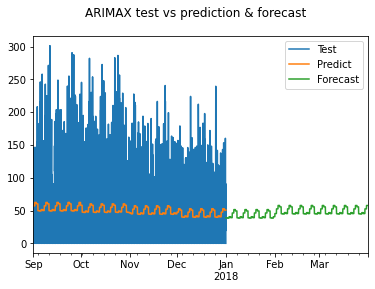

In [10]:
# testing model to see prediction/forecast/test dates are what we wanted and able to do metrics
arimax = sm.tsa.statespace.SARIMAX(train,order=(0,0,0),seasonal_order=(0,0,0,0),exog=exog_train,freq='h',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
pred = arimax.predict('2017-08-31 23','2017-12-31 23',exog = exog_test)[1:]
print('test start:', test.head())
print('test end:', test.tail())
print('pred start:', pred.head())
print('pred end:', pred.tail())
forecast = arimax.predict('2017-12-31 23','2018-03-31 23',exog = exog_forecast)[1:]
print('forecast start:', forecast.head())
print('forecast end:', forecast.head())
# testing and see if we can calculate all metrics
print('ARIMAX model R2:', r2_score(test,pred))
print('ARIMAX model MSE:', mean_squared_error(test,pred))
print('ARIMAX model MAE:', mean_absolute_error(test,pred))
print('ARIMAX model smape:', smape(test,pred))
print('ARIMAX model AIC:', arimax.aic)
# testing and see if we can make it into dataframe and view the plot
pd.DataFrame({'test':test.sales,'pred':pred,'forecast':forecast},).plot()
plt.suptitle('ARIMAX test vs prediction & forecast')
plt.legend(["Test", "Predict", "Forecast"])
plt.show()

In [ ]:
# Grid search for best params
#Grid search method for best parameters based on R2, smape, and AIC
#create empty lists to store values
p_list = []
d_list = []
q_list = []
R2_list = []
SMAPE_list = []
AIC_list = []
#iternation
for p in range(11):     #when p is 4 and up q cannot be 2 or higher
        for q in range(11): # see comment above, so i did 2 grid search with p up to 3 and q up to 10 then p 4~10 q 0~1
            # fit the model, trend is constant number which should be daily average sales
            arimax = sm.tsa.statespace.SARIMAX(train,order=(p,0,q),seasonal_order=(0,0,0,0),exog=exog_train,freq='h',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
            #predict 
            pred = arimax.predict('2017-08-31 23','2017-12-31 23',exog = exog_test)[1:]
            # append the values (caculate)
            p_list.append(p)
            d_list.append(0)
            q_list.append(q)
            R2_list.append(r2_score(test,pred))
            SMAPE_list.append(smape(test,pred))
            AIC_list.append(arimax.aic)
#create a dict to store the key:values then change to dataframe for easier/cleaner access
arimax_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'R2': R2_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}
arimax_score_df = pd.DataFrame.from_dict(arimax_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
#arimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimaxHGS.csv',
                      index=False)

In [11]:
# load the grid search data
arimax_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimaxHGS.csv')
display(arimax_score_df.loc[arimax_score_df['R2']==arimax_score_df.R2.max()])
display(arimax_score_df.loc[arimax_score_df['SMAPE']==arimax_score_df.SMAPE.min()])
arimax_score_df.loc[arimax_score_df['AIC']==arimax_score_df.AIC.min()]

,p,d,q,R2,SMAPE,AIC
31,2,0,9,0.249702,126.656863,140921.148731


,p,d,q,R2,SMAPE,AIC
31,2,0,9,0.249702,126.656863,140921.148731


,p,d,q,R2,SMAPE,AIC
31,2,0,9,0.249702,126.656863,140921.148731


C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


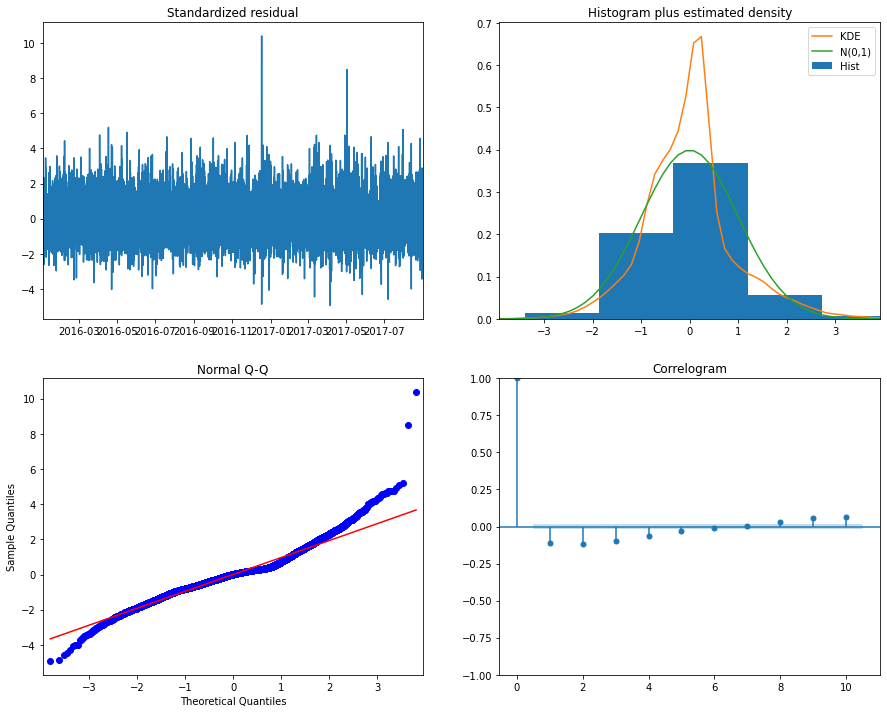

ARIMAX model R2: 0.2497017104409487
ARIMAX model MSE: 3010.6658137053587
ARIMAX model MAE: 45.40837714858918
ARIMAX model smape: 126.65686314745503
ARIMAX model AIC: 140921.14873121923


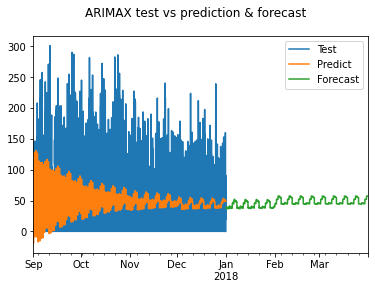

NameError: name 'R2_list' is not defined

In [12]:
#the whole shibam with optimal p/d/q
# fit
arimax = sm.tsa.statespace.SARIMAX(train,order=(2,0,9),seasonal_order=(0,0,0,0),exog=exog_train,freq='h',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()

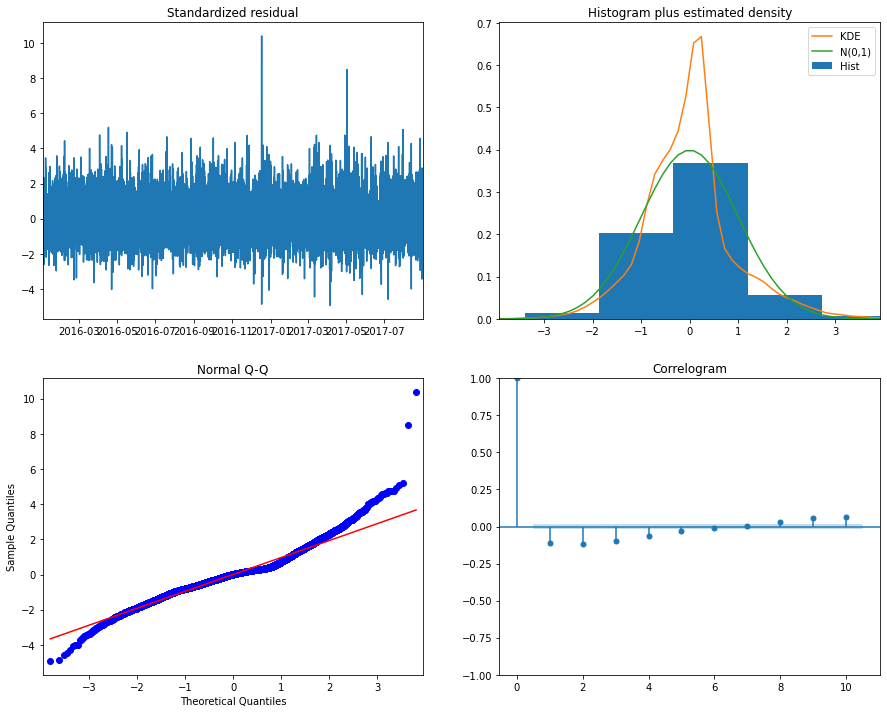

In [16]:
#get the diagnostics for the model
arimax.plot_diagnostics(figsize=(15, 12))
plt.savefig('arimax-H diagnostics.png')
plt.show()

Standardized residual seem sto have outliers (more than 3x std) quiet often
Histogram doesn't look too normalized
Normalized Q-Q doesn't fit too well compared to daily model

ARIMAX model R2: 0.2497017104409487
ARIMAX model MSE: 3010.6658137053587
ARIMAX model MAE: 45.40837714858918
ARIMAX model smape: 126.65686314745503
ARIMAX model AIC: 140921.14873121923


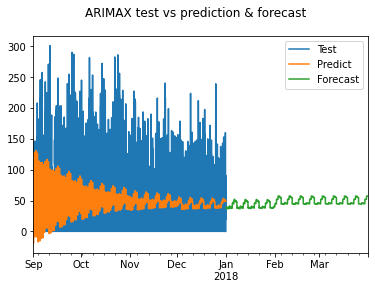

In [17]:
# predict and forecast
pred = arimax.predict('2017-08-31 23','2017-12-31 23',exog = exog_test)[1:]
forecast = arimax.predict('2017-12-31 23','2018-03-31 23',exog = exog_forecast)[1:]
# print metric scores
print('ARIMAX model R2:', r2_score(test,pred))
print('ARIMAX model MSE:', mean_squared_error(test,pred))
print('ARIMAX model MAE:', mean_absolute_error(test,pred))
print('ARIMAX model smape:', smape(test,pred))
print('ARIMAX model AIC:', arimax.aic)
# plot
pd.DataFrame({'test':test.sales,'pred':pred,'forecast':forecast},).plot()
plt.suptitle('ARIMAX test vs prediction & forecast')
plt.legend(["Test", "Predict", "Forecast"])
plt.savefig('arimax-H_test_pred.png')
plt.show()
#record the metrics and model name
model_list.append('ARIMAX')
r2_list.append(r2_score(test,pred))
mean_SE_list.append(mean_squared_error(test,pred))
mean_AE_list.append(mean_absolute_error(test,pred))
smape_list.append(smape(test,pred))
aic_list.append(arimax.aic)

The model scores are mostly better than Daily model's, but the AIC is way off when compared to daily model's AIC.

# SARIMAX

In [21]:
# Grid search for best params
#Since we are setting seasonality in daily basis, m=24
#we know d = 0 b/c dataset is stationary, we will leave it as it is.
#for SARIMAX the higher the order the slower it takes, we will evenly distribute to maximum order of 12; maximum p/P/q/Q=3
#D is usually 0 or 1
#create empty lists to store values
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#gridsearch iternation
for p in range(3):
    for d in range(2):
        for q in range(3):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        # fit the model
                        sarimax = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,24), freq='h',
                                                           exog=exog_train,
                                                           enforce_stationarity=False, 
                                                           enforce_invertibility=False,).fit()
                        # get the prediction & forecast
                        pred = sarimax.predict('2017-08-31 23','2017-12-31 23',exog = exog_test)[1:]
                        forecast = sarimax.predict('2017-12-31 23','2018-03-31 23',exog = exog_forecast)[1:]
                        # calculate the MSE and smape
                        MSE = mean_squared_error(test,pred)
                        SMAPE = smape(test,pred)
                        # append the values
                        p_list.append(p)
                        d_list.append(d)
                        q_list.append(q)
                        P_list.append(P)
                        D_list.append(D)
                        Q_list.append(Q)
                        MSE_list.append(MSE)
                        SMAPE_list.append(SMAPE)
                        AIC_list.append(sarimax.aic)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#create a dict to store the key:values then change to dataframe for easier/cleaner access
sarimax_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'P': P_list,
    'D': D_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

In [ ]:
# make it to dataframe and save
sarimax_score_df = pd.DataFrame.from_dict(sarimax_score_dict)
sarimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimaxH_gridsearch1.csv',
                       index=False)

In [18]:
sarimax_score_df1 = pd.read_csv(
    'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimaxH_gridsearch1.csv')
sarimax_score_df1

,p,d,q,P,D,Q,MSE,SMAPE,AIC
0,0,0,0,0,0,0,3993.993831,131.264349,189057.188403
1,0,0,0,0,0,1,3985.390880,131.197220,155009.739209
2,0,0,0,0,0,2,3978.573091,131.138856,153775.717086
3,0,0,0,0,1,0,992.735889,115.953687,143957.966025
4,0,0,0,0,1,1,931.712720,115.113913,136242.497836
5,0,0,0,0,1,2,927.013475,115.027997,135848.346070
6,0,0,0,1,0,0,3780.618979,129.923203,142683.844732
7,0,0,0,1,0,1,2221.270145,120.879560,137491.351442
8,0,0,0,1,0,2,1946.808241,119.206217,136941.272598
9,0,0,0,1,1,0,1023.043855,116.459802,140609.997430


In [19]:
# Grid search for best params
#Since we are setting seasonality in daily basis, m=24
#we know d = 0 b/c dataset is stationary, we will leave it as it is.
#for SARIMAX the higher the order the slower it takes, we will evenly distribute to maximum order of 12; maximum p/P/q/Q=3
#D is usually 0 or 1
#create empty lists to store values
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#gridsearch iternation
#for p in range(3):
#    for q in range(3):
#        for P in range(3):
#            for D in [0,1]:
for Q in range(3):
    # fit the model
    sarimax = sm.tsa.statespace.SARIMAX(train, order=(0,0,0), seasonal_order=(2,1,Q,24), freq='h', exog=exog_train,
                                        enforce_stationarity=False, enforce_invertibility=False,).fit()
    # get the prediction & forecast
    pred = sarimax.predict('2017-08-31 23','2017-12-31 23',exog = exog_test)[1:]
    forecast = sarimax.predict('2017-12-31 23','2018-03-31 23',exog = exog_forecast)[1:]
    # calculate the MSE and smape
    MSE = mean_squared_error(test,pred)
    SMAPE = smape(test,pred)
    # append the values
    p_list.append(0)
    d_list.append(0)
    q_list.append(0)
    P_list.append(2)
    D_list.append(1)
    Q_list.append(Q)
    MSE_list.append(MSE)
    SMAPE_list.append(SMAPE)
    AIC_list.append(sarimax.aic)

KeyboardInterrupt: 

In [ ]:
# load the grid search data
sarimax_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimaxH_gridsearch.csv')
display(sarimax_score_df.loc[sarimax_score_df['MSE']==sarimax_score_df.MSE.min()])
display(sarimax_score_df.loc[sarimax_score_df['SMAPE']==sarimax_score_df.SMAPE.min()])
sarimax_score_df.loc[sarimax_score_df['AIC']==sarimax_score_df.AIC.min()]

In [ ]:
# create a function like ARIMA101 but for SARIMAX
def SARIMAX101(p, q, P, D, Q):
    #fit the model with given params
    sarimax = sm.tsa.statespace.SARIMAX(train,order=(p,0,q),seasonal_order=(P,D,Q,7),exog=exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    sarimax.plot_diagnostics(figsize=(15, 12))
    plt.savefig('sarimax{}_diagnostics.png'.format(str(p)+str(q)))
    plt.show()
    #predict using the model
    pred = sarimax.predict('2017-08-31','2017-12-31',exog = exog_test)[1:]
    forecast = sarimax.predict('2017-12-31','2018-03-31',exog = exog_forecast)[1:]
    #record the metrics and model name
    model_list.append('SARIMAX{}'.format(str(p)+str(q)))
    R2_list.append(r2_score(test,pred))
    mean_SE_list.append(mean_squared_error(test,pred))
    mean_AE_list.append(mean_absolute_error(test,pred))
    smape_list.append(smape(test,pred))
    aic_list.append(sarimax.aic)
    print('SARIMAX{} model R2:'.format(str(p)+str(q)), r2_score(test,pred))
    print('SARIMAX{} model MSE:'.format(str(p)+str(q)), mean_squared_error(test,pred))
    print('SARIMAX{} model MAE:'.format(str(p)+str(q)), mean_absolute_error(test,pred))
    print('SARIMAX{} model smape:'.format(str(p)+str(q)), smape(test,pred))
    print('SARIMAX{} model AIC:'.format(str(p)+str(q)), sarimax.aic)
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred,'forecast':forecast}).plot()
    plt.suptitle('SARIMAX{} test vs prediction & forecast'.format(str(p)+str(q)))
    plt.legend(["Test", "Predict", "Forecast"])
    plt.savefig('sarimax{}_test_pred.png'.format(str(p)+str(q)))
    plt.show()
    return

In [ ]:
SARIMAX101(0,0,1,0,1)

In [ ]:
SARIMAX101(1,2,0,1,2)

In [ ]:
# create a dict that had all the model score info
model_score_dict = {
    'model': model_list,
    'R2': R2_list,
    'MSE': mean_SE_list,
    'MAE': mean_AE_list,
    'smape': smape_list,
    'AIC': aic_list,
}
# change it to dataframe for easier math usage
model_score_df = pd.DataFrame.from_dict(model_score_dict)
# save the dataframe
model_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\model_scores.csv',
                     index=False)

In [ ]:
# read the model scores
model_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\model_scores.csv')
model_score_df

In [ ]:
# let's view each metric's winner
display(model_score_df.loc[model_score_df['R2']==model_score_df.R2.max()])
display(model_score_df.loc[model_score_df['MSE']==model_score_df.MSE.min()])
display(model_score_df.loc[model_score_df['MAE']==model_score_df.MAE.min()])
display(model_score_df.loc[model_score_df['smape']==model_score_df.smape.min()])
display(model_score_df.loc[model_score_df['AIC']==model_score_df.AIC.min()])

It appears that SARIMA has the best overall scores, even though HES had lowest AIC its other scores are horrible.
Let's take a look at the their test vs predict & forecast.

In [ ]:
from IPython.display import Image
Image(filename='sarima003200_test_pred.png') 

In [ ]:
Image(filename='sarima101002_test_pred.png') 

In [ ]:
Image(filename='HES_test_pred.png') 

Absolutely unacceptable, from the monthly sums, we could tell that March should be more than January. So the above models with its given parameters are not acceptable.
The only model that had such pattern was ARIMAX&SARIMAX, let's take a look at its score and test vs prediction & orecast.

In [ ]:
# let's make a dataframe with only these two models
arimax_models = model_score_df.loc[model_score_df['model'].str.startswith('ARIMAX')]
sarimax_models = model_score_df.loc[model_score_df['model'].str.startswith('SARIMAX')]
x_models = pd.concat([arimax_models, sarimax_models])
x_models.sort_values('MSE')

In [ ]:
# arimax904
Image(filename='arimax904_test_pred.png') 

In [ ]:
# sarimax000101
Image(filename='sarimax00_test_pred.png') 

In [ ]:
# arimax000
Image(filename='arimax000_test_pred.png') 

It looks like the day of week and month features helped a lot. All these three plots look very similar, except that arimax904 seems to suggest a slightly higher spike on every other week.
If there were more data, it would have taken longer to run SARIMAX, so I'd personally recommend running the ARIMAX model with more parameters to adjust with in the grid search.